In [23]:
import pandas as pd

data_row=pd.read_csv("/Users/withmocha/Desktop/DATA/Capston Design(2024)/data(sentence)/0504/gpt/train/use gpt/gpt train data.csv",index_col=0)

data_row

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,predict
0,0.054102,-0.066255,-0.016948,-0.014147,0.002676,-0.004337,-0.020460,0.002210,0.072026,-0.016116,...,-0.039752,-0.011470,0.007960,-0.043131,-0.072515,0.016914,0.024208,0.015908,-0.016616,0
1,0.050208,-0.072811,-0.016652,-0.018788,-0.004397,-0.004018,-0.037195,0.011755,0.054287,-0.015238,...,-0.051621,-0.007345,0.010965,-0.039393,-0.049577,0.035705,0.022245,0.011584,-0.001973,0
2,0.074532,-0.003069,-0.029463,0.010639,0.003859,0.000853,-0.017487,0.010705,0.083100,-0.006545,...,0.003845,0.022685,-0.005338,-0.037020,-0.078075,0.011398,0.024196,0.018187,-0.031964,2
3,0.054348,-0.031571,-0.016646,-0.006379,0.035901,0.020960,-0.070056,0.024137,0.061972,-0.004382,...,-0.026560,0.002230,-0.014480,-0.051855,-0.072857,-0.005117,0.017494,0.027539,-0.019939,0
4,0.042024,-0.038339,-0.029860,0.026027,0.017407,-0.016309,-0.034739,0.026765,0.045727,0.009239,...,-0.001934,0.002913,0.014456,-0.014281,-0.009743,-0.000630,0.018181,-0.002410,-0.050316,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.103314,-0.055173,-0.020592,0.040117,0.033047,0.013462,-0.041553,0.026483,0.077640,-0.022566,...,-0.004895,-0.002905,0.013308,-0.044995,-0.075419,0.004471,0.014530,0.021715,-0.006937,1
2996,0.061798,-0.074197,-0.035188,-0.006774,0.025795,-0.003459,-0.001813,0.002595,0.045659,-0.009938,...,-0.038762,-0.015197,0.006406,-0.051039,-0.047180,0.004870,0.025200,0.006964,-0.029941,0
2997,0.038410,-0.094417,-0.026671,-0.021278,-0.008343,-0.006640,0.017228,-0.006007,0.056434,-0.007206,...,-0.039643,-0.026327,0.020404,-0.029640,-0.045425,0.022187,0.017653,-0.002580,-0.021919,0
2998,0.038844,-0.038090,-0.028100,0.011259,0.028264,-0.014000,-0.063765,0.033624,0.039392,-0.020629,...,-0.012488,0.028551,-0.018211,-0.030303,-0.066341,0.023137,0.024972,0.007984,-0.018709,0


In [24]:

import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")
device = torch.device("mps")  # MPS 장치 사용

tensor([1.], device='mps:0')


In [25]:
import math
import torch
from torch.optim.optimizer import Optimizer

class PADAM(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, partial=1/4):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))

        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, partial=partial)
        super(PADAM, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('PADAM does not support sparse gradients')

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(p.data, alpha=group['weight_decay'])

                exp_avg.mul_(beta1).add_(grad, alpha=1-beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1-beta2)

                denom = exp_avg_sq.sqrt().add_(group['eps'])
                step_size = group['lr'] * math.pow(state['step'], -group['partial'])

                p.data.addcdiv_(exp_avg, denom, value=-step_size)

        return loss

In [26]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [27]:
# 데이터 불러오기 및 전처리
data_row = pd.read_csv("/Users/withmocha/Desktop/DATA/Capston Design(2024)/data(sentence)/0504/gpt/train/use gpt/gpt train data.csv", index_col=0)
y_train = pd.get_dummies(data_row['predict']).values
X_train = data_row.drop(columns=['predict']).values

test = pd.read_csv("/Users/withmocha/Desktop/DATA/Capston Design(2024)/data(sentence)/0504/gpt/test/use gpt/gpt test data.csv", index_col=0)
test_y = pd.get_dummies(test['predict']).values
test_x = test.drop(columns=['predict']).values

In [28]:

X_train = torch.tensor(X_train, dtype=torch.float).unsqueeze(1).to(device)
y_train = torch.tensor(y_train, dtype=torch.float).to(device)
test_x = torch.tensor(test_x, dtype=torch.float).unsqueeze(1).to(device)
test_y = torch.tensor(test_y, dtype=torch.float).to(device)

In [29]:
print(X_train.shape)
print(y_train.shape)
print(test_x.shape)
print(test_y.shape)

torch.Size([3000, 1, 768])
torch.Size([3000, 3])
torch.Size([300, 1, 768])
torch.Size([300, 3])


In [30]:

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)

test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, shuffle=False)

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class TextClassifier(nn.Module):
    def __init__(self):
        super(TextClassifier, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=X_train.shape[2], out_channels=128, kernel_size=2, padding=1)  # 채널 수와 커널 사이즈 조정
        self.bn1 = nn.BatchNorm1d(128)  # 배치 정규화 추가
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=2, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=2, padding=1)
        self.bn3 = nn.BatchNorm1d(32)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.dropout = nn.Dropout(0.25)  # 드롭아웃 비율 조정
        self.lstm = nn.LSTM(input_size=32, hidden_size=128, num_layers=2, batch_first=True, bidirectional=True)  # LSTM 구조 보강
        self.fc1 = nn.Linear(128*2, 32)  # Fully connected 레이어의 크기 조정
        self.fc2 = nn.Linear(32, 3)
        self.activation = nn.ReLU()  # 활성화 함수 변경

    def forward(self, x):
        x = self.bn1(self.activation(self.conv1(x)))
        x = self.pool(x)
        x = self.bn2(self.activation(self.conv2(x)))
        x = self.pool(x)
        x = self.bn3(self.activation(self.conv3(x)))
        x = self.pool(x)
        x = self.dropout(x)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


model = TextClassifier().to(device)
model.to(device)

TextClassifier(
  (conv1): Conv1d(768, 128, kernel_size=(2,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 64, kernel_size=(2,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(64, 32, kernel_size=(2,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (lstm): LSTM(32, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=256, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=3, bias=True)
  (activation): ReLU()
)

In [32]:
import torch.optim as optim


criterion = nn.CrossEntropyLoss()
optimizer = PADAM(model.parameters(), lr=0.002,weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=3, verbose=True)

/opt/anaconda3/envs/conda_cpu/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [33]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

def save_checkpoint(state, filename="my_checkpoint.pt"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

In [34]:
num_epochs = 500
training_losses = []
validation_losses = []


patience = 20  
counter = 0  
best_loss = None  

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # 데이터를 MPS 장치로 이동
        inputs = inputs.permute(0, 2, 1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, torch.max(labels, 1)[1])
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    training_losses.append(avg_train_loss)
    
   
    model.eval()
    validation_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device) 
            inputs = inputs.permute(0, 2, 1)  
            outputs = model(inputs)
            loss = criterion(outputs, torch.max(labels, 1)[1])
            validation_loss += loss.item()
    
    avg_validation_loss = validation_loss / len(test_loader)
    validation_losses.append(avg_validation_loss)

    print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss}, Validation Loss: {avg_validation_loss}')
    
    scheduler.step(avg_validation_loss)
    
    if best_loss is None:
        best_loss = avg_validation_loss
        save_checkpoint({'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()})
    elif avg_validation_loss < best_loss:
        best_loss = avg_validation_loss
        save_checkpoint({'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()})
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping!")
            break

print('Test Fine End')



Epoch 1, Training Loss: 0.5940474485357602, Validation Loss: 0.44515203809055187
=> Saving checkpoint
Epoch 2, Training Loss: 0.43249423503875734, Validation Loss: 0.43436618747926936
=> Saving checkpoint
Epoch 3, Training Loss: 0.38859375938773155, Validation Loss: 0.38252816073654683
=> Saving checkpoint
Epoch 4, Training Loss: 0.355580972135067, Validation Loss: 0.34511331690727576
=> Saving checkpoint
Epoch 5, Training Loss: 0.3162218044201533, Validation Loss: 0.3139165772242753
=> Saving checkpoint
Epoch 6, Training Loss: 0.28989987075328827, Validation Loss: 0.2953852127143667
=> Saving checkpoint
Epoch 7, Training Loss: 0.2627861005564531, Validation Loss: 0.25481420008839145
=> Saving checkpoint
Epoch 8, Training Loss: 0.23906492479145527, Validation Loss: 0.32447294810888705
Epoch 9, Training Loss: 0.2317660121868054, Validation Loss: 0.24662234270855454
=> Saving checkpoint
Epoch 10, Training Loss: 0.21030999658008417, Validation Loss: 0.2740942275214184
Epoch 11, Training L

In [35]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np



torch.save(model.state_dict(), 'pytorch cnn-bilstm model_state_dict0424.pt')

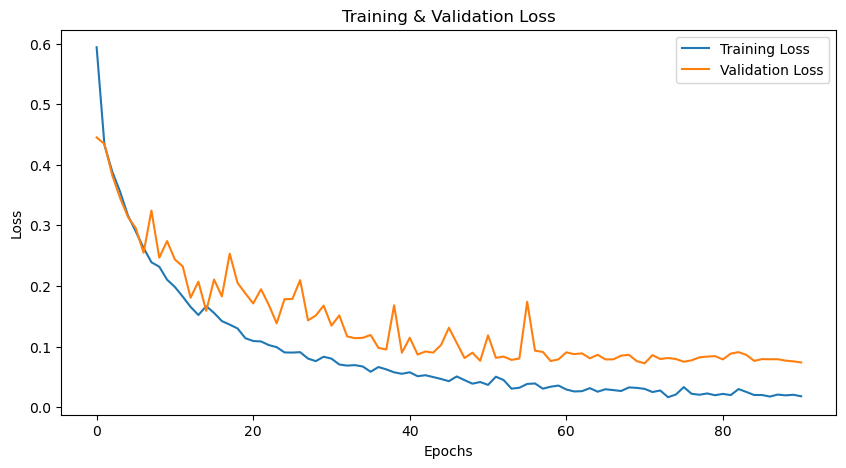

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

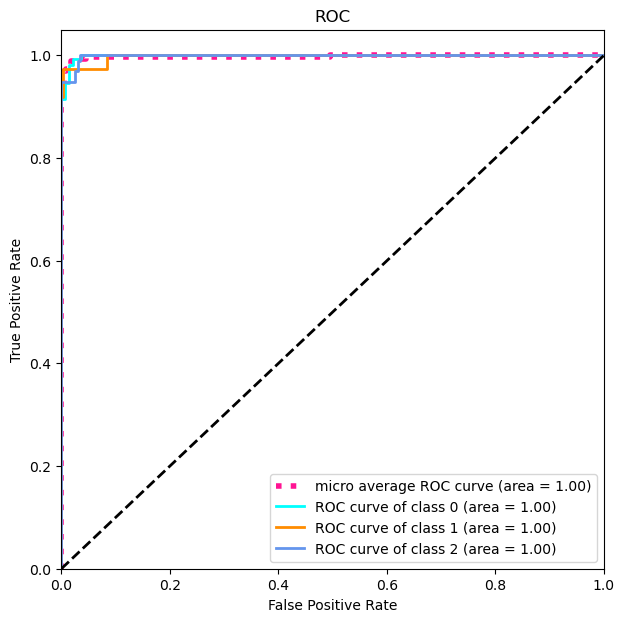

In [37]:

def plot_multiclass_roc_curve(test_y, y_score, n_classes):
   
    test_y_bin = label_binarize(test_y, classes=[*range(n_classes)])

    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(test_y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

   
    fpr["micro"], tpr["micro"], _ = roc_curve(test_y_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

   
    plt.figure(figsize=(7, 7))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()





from sklearn.preprocessing import label_binarize

test_x = test_x.permute(0, 2, 1) 
y_score = model(test_x).detach().cpu().numpy()

test_y = test_y.detach().cpu().numpy()

plot_multiclass_roc_curve(test_y, y_score, n_classes=3)

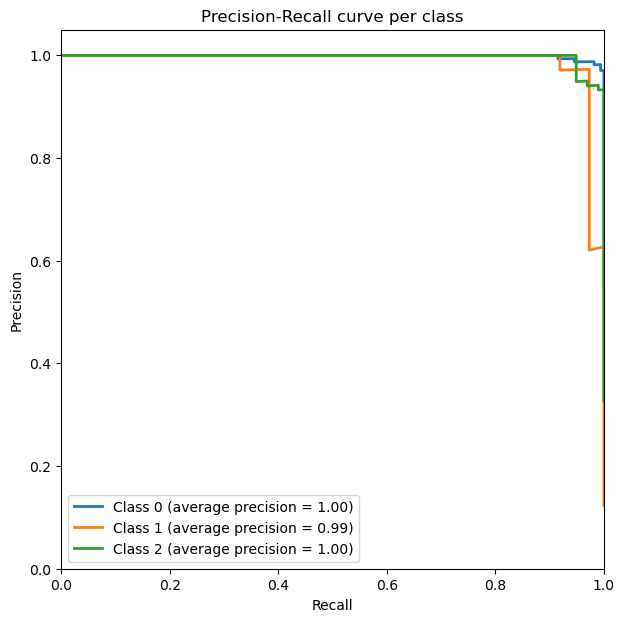

In [38]:
def plot_precision_recall_curve(test_y, y_score, n_classes):
    
    test_y = label_binarize(test_y, classes=[*range(n_classes)])
    
   
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(test_y[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(test_y[:, i], y_score[:, i])

    
    plt.figure(figsize=(7, 7))
    for i in range(n_classes):
        plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (average precision = {average_precision[i]:0.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve per class')
    plt.legend(loc="best")
    plt.show()
    
plot_precision_recall_curve(test_y, y_score, n_classes=3)

In [39]:

y_pred = np.argmax(y_score, axis=1)
test_y_labels = np.argmax(test_y, axis=1)  # 실제 레이블

In [40]:

accuracy = accuracy_score(test_y_labels, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9766666666666667


In [41]:
# 혼동 행렬
conf_matrix = confusion_matrix(test_y_labels, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[162   1   2]
 [  1  36   0]
 [  2   1  95]]


In [42]:
with open("CNN BILSTM confusion matrix.txt", "w") as text_file:
    print(confusion_matrix(test_y_labels, y_pred), file=text_file)

In [43]:
# 분류 보고서
class_report = classification_report(test_y_labels, y_pred)
print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       165
           1       0.95      0.97      0.96        37
           2       0.98      0.97      0.97        98

    accuracy                           0.98       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.98      0.98      0.98       300



In [44]:
with open("CNN-BILSTM output.txt", "w") as text_file:
    print(classification_report(test_y_labels, y_pred,digits=4), file=text_file)